# This notebook downloads and prepares the data COVDI-19 data form the CDC website

Data is available here:
- https://usafacts.org/visualizations/coronavirus-covid-19-spread-map


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
%matplotlib inline

import psycopg2 as pg
from sqlalchemy import create_engine 
import time
import sys
# sys.path.insert(1, r"") 
# import cred2 as cred # for db connection
from tqdm import tqdm

# Procedure: Preprocess the covid data

1. Melt the data into the correct form
2. Un-cumulate the data for each county
3. (Upload data to DB)

Note: Not necessary to run this script when "county_cases_2020_to_2022.csv" and "county_deaths_2020_to_2022.csv" already exist!

## Functions

In [2]:
def plot_df(df):
    sns.set(rc={'figure.figsize':(11,8)})
    sns.lineplot(
        x='date',
        y='counts',
        data= df)
    plt.show()

def plot_uncumulated_data(df, fip):
    plt.figure(figsize=(10, 5))

    # Set the x-axis as dates
    plt.plot(df.index, df[fip], label='Value')

    # Set the number of date ticks to display (e.g., 10)
    num_ticks = 10

    # Calculate the step for date ticks
    step = len(df) // num_ticks
    date_ticks = df.index[::step]

    # Set the date ticks on the x-axis
    plt.xticks(date_ticks, rotation=45)  # Rotate date labels for readability

    # Label the x and y axes
    plt.xlabel('Date')
    plt.ylabel('Value')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()

In [3]:
def calculate_daily_new_cases(df, fips_column, cases_column):
    """
    Calculate daily new cases for all counties in a DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing cumulative cases data.
        fips_column (str): The column name containing the FIPS code or identifier.
        cases_column (str): The column name containing cumulative cases.

    Returns:
        pd.DataFrame: A DataFrame containing daily new cases for all counties.
    """
    df = df.sort_values('date')
    daily_new_cases_dict = {}
    county_fips = list(set(df[fips_column]))
    
    for fip in tqdm(county_fips):
        # Filter the DataFrame for the specified county
        county_df = df[df[fips_column] == fip]
        
        # Calculate daily new cases and handle the first row
        daily_new_cases = county_df[cases_column].diff().fillna(0).clip(lower=0).astype('int64')
        daily_new_cases.iloc[0] = county_df.iloc[0][cases_column]
    
        # Reset the index for the daily new cases DataFrame
        daily_new_cases.reset_index(drop=True, inplace=True)

        # Store daily new cases DataFrame in the dictionary with FIPS code as the key
        daily_new_cases_dict[fip] = daily_new_cases

    # Concatenate daily new cases DataFrames into a single DataFrame
    daily_new_cases_df = pd.concat(daily_new_cases_dict, axis=1)

    return daily_new_cases_df

## Load the data

In [4]:
#download the data from 
# https://usafacts.org/visualizations/coronavirus-covid-19-spread-map

cases = pd.read_csv('../../../data/covid19_cases/covid_confirmed_usafacts.csv')

In [7]:
cases

,countyFIPS,County Name,State,StateFIPS,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,...,2023-07-14,2023-07-15,2023-07-16,2023-07-17,2023-07-18,2023-07-19,2023-07-20,2023-07-21,2023-07-22,2023-07-23
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,19913,19913,19913,19913,19913,19913,19913,19913,19913,19913
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,70521,70521,70521,70521,70521,70521,70521,70521,70521,70521
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,7582,7582,7582,7582,7582,7582,7582,7582,7582,7582
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,8149,8149,8149,8149,8149,8149,8149,8149,8149,8149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3188,56037,Sweetwater County,WY,56,0,0,0,0,0,0,...,12645,12645,12645,12645,12645,12645,12645,12645,12645,12645
3189,56039,Teton County,WY,56,0,0,0,0,0,0,...,12206,12206,12206,12206,12206,12206,12206,12206,12206,12206
3190,56041,Uinta County,WY,56,0,0,0,0,0,0,...,6468,6468,6468,6468,6468,6468,6468,6468,6468,6468
3191,56043,Washakie County,WY,56,0,0,0,0,0,0,...,2640,2640,2640,2640,2640,2640,2640,2640,2640,2640


## 1. Melt the data into the correct form

In [8]:
cases_melted = cases.melt(id_vars=["countyFIPS","County Name","State",'StateFIPS'], var_name="date", value_name="counts")

In [9]:
cases_melted

,countyFIPS,County Name,State,StateFIPS,date,counts
0,0,Statewide Unallocated,AL,1,2020-01-22,0
1,1001,Autauga County,AL,1,2020-01-22,0
2,1003,Baldwin County,AL,1,2020-01-22,0
3,1005,Barbour County,AL,1,2020-01-22,0
4,1007,Bibb County,AL,1,2020-01-22,0
...,...,...,...,...,...,...
4039140,56037,Sweetwater County,WY,56,2023-07-23,12645
4039141,56039,Teton County,WY,56,2023-07-23,12206
4039142,56041,Uinta County,WY,56,2023-07-23,6468
4039143,56043,Washakie County,WY,56,2023-07-23,2640


### Investigate

In [10]:
# check the data for one county!
oc = cases_melted[cases_melted['State']=='WY'].copy()
oc

,countyFIPS,County Name,State,StateFIPS,date,counts
3169,0,Statewide Unallocated,WY,56,2020-01-22,0
3170,56001,Albany County,WY,56,2020-01-22,0
3171,56003,Big Horn County,WY,56,2020-01-22,0
3172,56005,Campbell County,WY,56,2020-01-22,0
3173,56007,Carbon County,WY,56,2020-01-22,0
...,...,...,...,...,...,...
4039140,56037,Sweetwater County,WY,56,2023-07-23,12645
4039141,56039,Teton County,WY,56,2023-07-23,12206
4039142,56041,Uinta County,WY,56,2023-07-23,6468
4039143,56043,Washakie County,WY,56,2023-07-23,2640


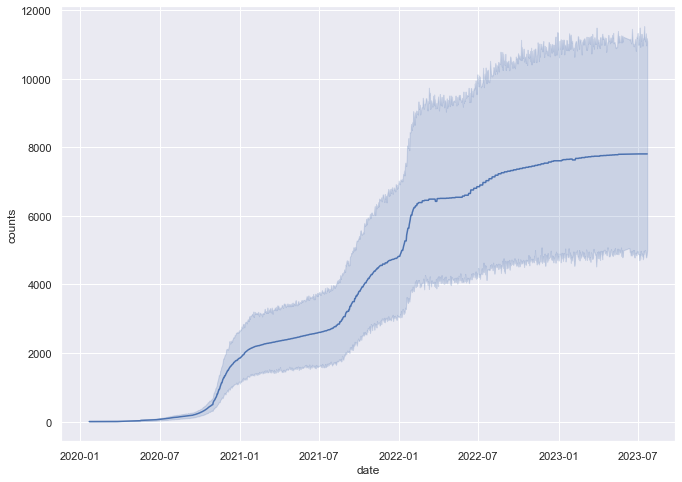

In [11]:
oc['date'] = pd.to_datetime(oc['date'])
plot_df(oc)
# what we see is that the cases are all cummulated for one county!

## 2. Un-cumulate the data for each county

Create the non-cumulative the data for each county.

In [12]:
# uncumulate the data
counts_per_date_per_state = cases_melted[['date','counts','State']].groupby(['State', 'date'])['counts'].sum()
    
    # Reset the index to make the grouped columns regular columns
counts_per_date_per_state = counts_per_date_per_state.reset_index()
counts_per_date_per_state

daily_new_cases = calculate_daily_new_cases(counts_per_date_per_state, 'State', 'counts') #skip cases without county! exclude zero! [cases_melted.countyFIPS.isin([0])==False]


100%|██████████| 51/51 [00:00<00:00, 236.09it/s]


In [13]:
# add dates!
dates_c = list(set(cases_melted.sort_values('date').date))
dates_c.sort()
daily_new_cases.index = dates_c

In [14]:
daily_new_cases.columns = [el.lower() for el in daily_new_cases.columns]
daily_new_cases

,nv,id,ms,il,nj,pa,ca,ks,wi,nd,...,ut,ky,wy,mt,ak,ne,hi,al,dc,wv
2020-01-22,0,0,0,0,0,0,722,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-23,0,0,0,0,0,0,11,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-24,0,0,0,1,0,0,6,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-25,0,0,0,0,0,0,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-01-26,0,0,0,0,0,0,7,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-19,0,0,0,0,0,0,0,0,112,0,...,0,0,0,0,0,0,0,0,0,0
2023-07-20,523,0,0,0,0,0,0,0,94,0,...,0,0,0,0,0,0,0,0,0,105
2023-07-21,0,0,0,0,0,0,0,0,0,91,...,0,0,0,0,0,0,676,0,0,0
2023-07-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Testing

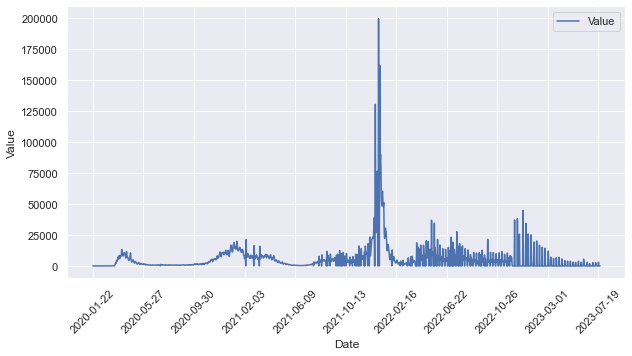

In [15]:
plot_uncumulated_data(daily_new_cases, 'ny')

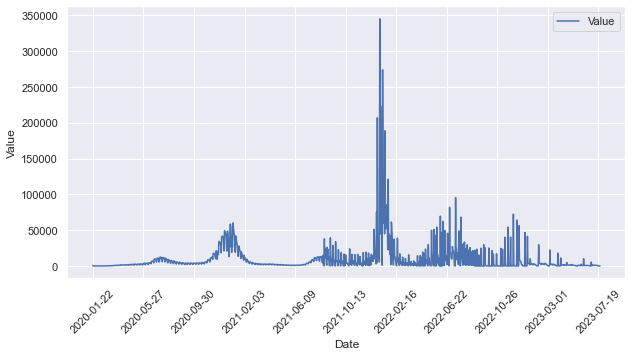

In [16]:
plot_uncumulated_data(daily_new_cases, 'ca')

##  Safe and upload data to DB

In [17]:
daily_new_cases.to_csv(r'../../../data/covid19_cases/daily_new_cases_state.csv')

In [18]:
# # DB functions
# # get data from the database
# def getData(query, conn):
#     df = pd.read_sql_query(query, con=conn)
#     return df

# # get a new Cursor
# def getCursor():
#     import sys
#     sys.path.insert(1, r"")
#     import cred2 as cred

#     conn = pg.connect(
#         user= cred.user,
#         dbname = cred.dbname,
#         host = cred.host,
#         port = cred.port,
#         password = cred.password
#     )
#     cur = conn.cursor()
#     return cur, conn

# # create engine
# username = cred.user
# password = cred.password
# host = cred.host
# database = cred.dbname
# port = str(cred.port)
# engine = create_engine('postgresql://'+username+':'+password+'@'+host+':'+port+'/'+database)
# daily_new_cases.columns = [str(el) for el in daily_new_cases.columns]
# cur, conn = getCursor()
# daily_new_cases.T.to_sql(name = 'county_cases_2020_to_2023', schema = 'covid', con = engine, if_exists='replace', index = False)
# conn.close()